<a href="https://colab.research.google.com/github/Shreeyamshu/TestoTesto/blob/main/WLVID_Portfolio_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5CS037 - Concepts and Technologies of AI
# Final Portfolio Project
**Classification:** Stroke Prediction  
**Regression:** Coffee & Sleep Analysis

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             mean_squared_error, r2_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Upload CSV files
from google.colab import files
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv
Saving synthetic_coffee_health_10000.csv to synthetic_coffee_health_10000.csv


## PART A: CLASSIFICATION - Stroke Prediction
Dataset aligns with SDG 3: Good Health and Well-being

In [ ]:
df_class = pd.read_csv('healthcare-dataset-stroke-data.csv')
print("Shape:", df_class.shape)
df_class.head()

Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Check missing values
print("Missing values:")
print(df_class.isnull().sum())

Missing values:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [ ]:
# Check class distribution
print("Target distribution:")
print(df_class['stroke'].value_counts())
print(f"Imbalance ratio: {df_class['stroke'].value_counts()[0]/df_class['stroke'].value_counts()[1]:.1f}:1")

Target distribution:
stroke
0    4861
1     249
Name: count, dtype: int64
Imbalance ratio: 19.5:1


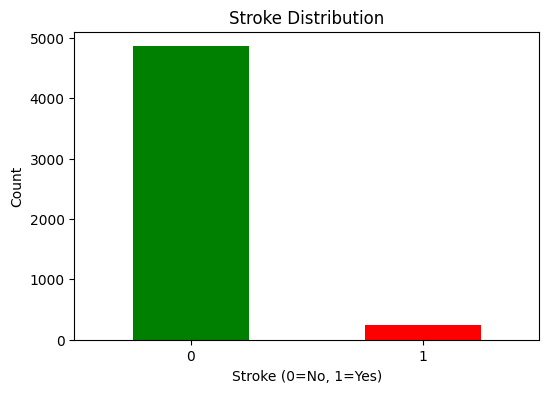

In [ ]:
# Visualize class imbalance
plt.figure(figsize=(6,4))
df_class['stroke'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Stroke Distribution')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_class.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


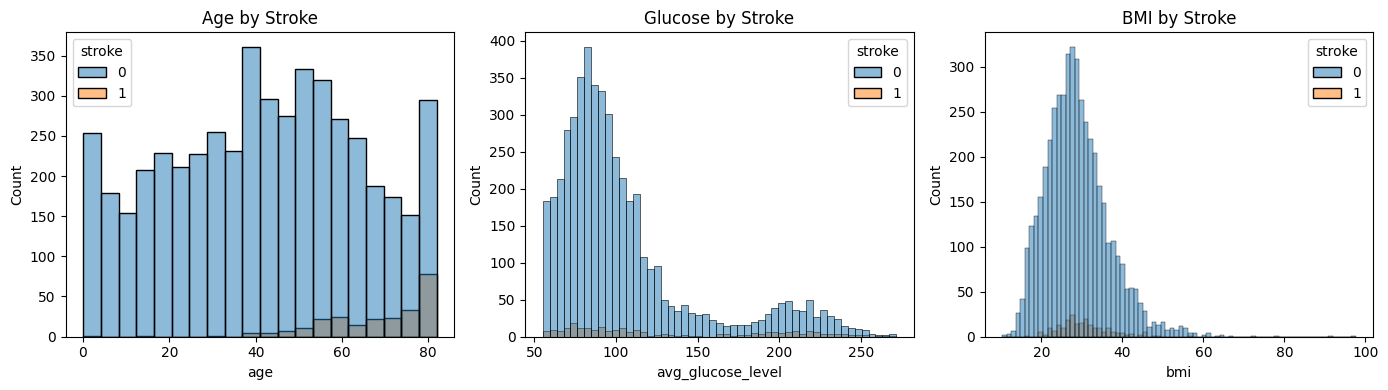

In [ ]:
# Age distribution by stroke
df_class['bmi'] = pd.to_numeric(df_class['bmi'], errors='coerce')

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(data=df_class, x='age', hue='stroke', ax=axes[0])
axes[0].set_title('Age by Stroke')

sns.histplot(data=df_class, x='avg_glucose_level', hue='stroke', ax=axes[1])
axes[1].set_title('Glucose by Stroke')

sns.histplot(data=df_class.dropna(subset=['bmi']), x='bmi', hue='stroke', ax=axes[2])
axes[2].set_title('BMI by Stroke')

plt.tight_layout()
plt.show()

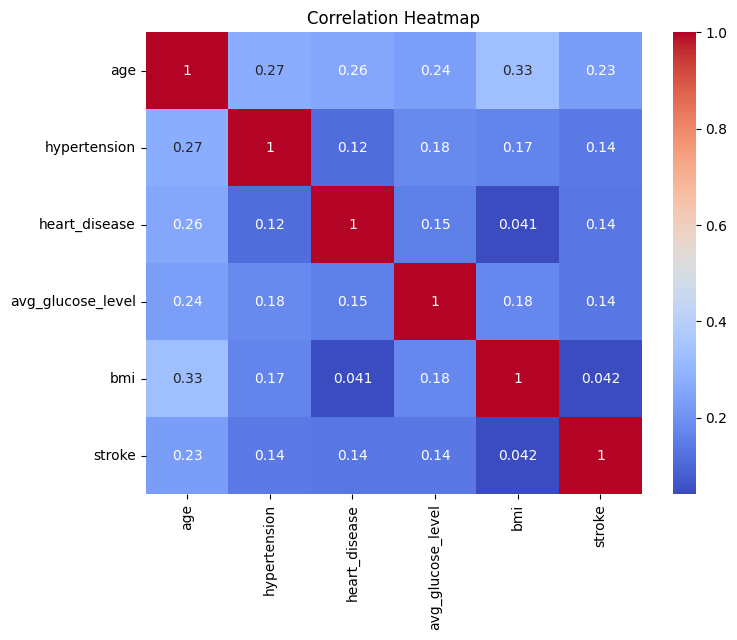

In [ ]:
# Correlation heatmap
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
plt.figure(figsize=(8, 6))
sns.heatmap(df_class[num_cols].dropna().corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Data preprocessing
df_processed = df_class.copy()
df_processed = df_processed.drop('id', axis=1)
df_processed['bmi'] = pd.to_numeric(df_processed['bmi'], errors='coerce')
df_processed['bmi'].fillna(df_processed['bmi'].median(), inplace=True)
df_processed = df_processed[df_processed['gender'] != 'Other']

# Encode categorical columns
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in cat_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

print("Processed shape:", df_processed.shape)

Processed shape: (5109, 11)


In [ ]:
# Split data
X = df_processed.drop('stroke', axis=1)
y = df_processed['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 4087, Test: 1022


### Neural Network Classifier

In [ ]:
class_weights = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}

model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train neural network
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_nn.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7929 - loss: 1.3957 - val_accuracy: 0.7090 - val_loss: 0.5306
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6930 - loss: 1.0788 - val_accuracy: 0.7347 - val_loss: 0.4903
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7146 - loss: 0.9905 - val_accuracy: 0.7421 - val_loss: 0.4636
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7150 - loss: 0.9852 - val_accuracy: 0.7262 - val_loss: 0.4747
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7076 - loss: 0.9532 - val_accuracy: 0.7396 - val_loss: 0.4571
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7101 - loss: 0.9424 - val_accuracy: 0.7469 - val_loss: 0.4504
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7043 - loss: 0.9726 - val_accuracy: 0.7555 - val_loss: 0.4385
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7061 - loss: 0.9770 - val_accuracy: 0.

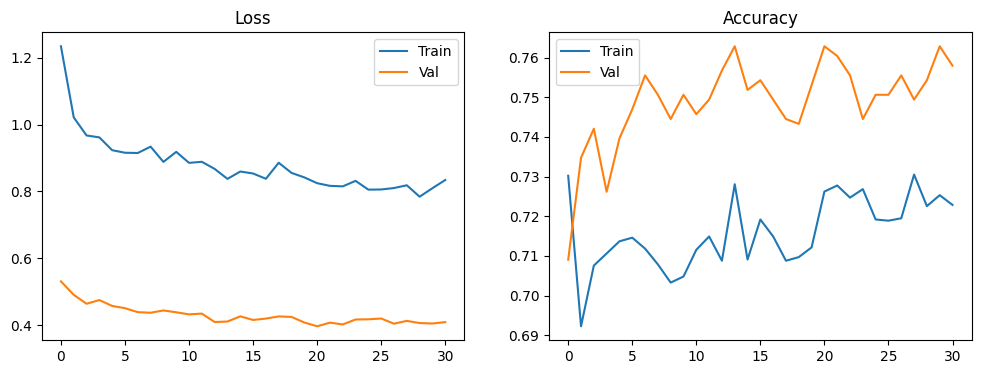

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Val')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

In [ ]:
# Evaluate neural network
y_pred_nn = (model_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()

nn_acc = accuracy_score(y_test, y_pred_nn)
nn_prec = precision_score(y_test, y_pred_nn, zero_division=0)
nn_rec = recall_score(y_test, y_pred_nn, zero_division=0)
nn_f1 = f1_score(y_test, y_pred_nn, zero_division=0)

print("Neural Network Results:")
print(f"Accuracy: {nn_acc:.4f}")
print(f"Precision: {nn_prec:.4f}")
print(f"Recall: {nn_rec:.4f}")
print(f"F1: {nn_f1:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Neural Network Results:
Accuracy: 0.7309
Precision: 0.1287
Recall: 0.7800
F1: 0.2210


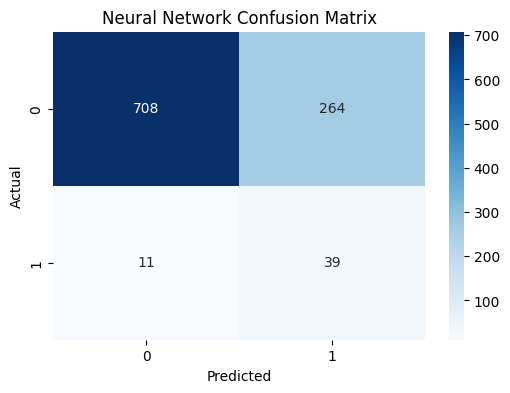

In [ ]:
# Confusion matrix for NN
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Classical Models

In [ ]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr, zero_division=0)
lr_rec = recall_score(y_test, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)

print("Logistic Regression Results:")
print(f"Accuracy: {lr_acc:.4f}, Precision: {lr_prec:.4f}, Recall: {lr_rec:.4f}, F1: {lr_f1:.4f}")

Logistic Regression Results:
Accuracy: 0.7358, Precision: 0.1333, Recall: 0.8000, F1: 0.2286


In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, zero_division=0)
rf_rec = recall_score(y_test, y_pred_rf, zero_division=0)
rf_f1 = f1_score(y_test, y_pred_rf, zero_division=0)

print("Random Forest Results:")
print(f"Accuracy: {rf_acc:.4f}, Precision: {rf_prec:.4f}, Recall: {rf_rec:.4f}, F1: {rf_f1:.4f}")

Random Forest Results:
Accuracy: 0.9501, Precision: 0.0000, Recall: 0.0000, F1: 0.0000


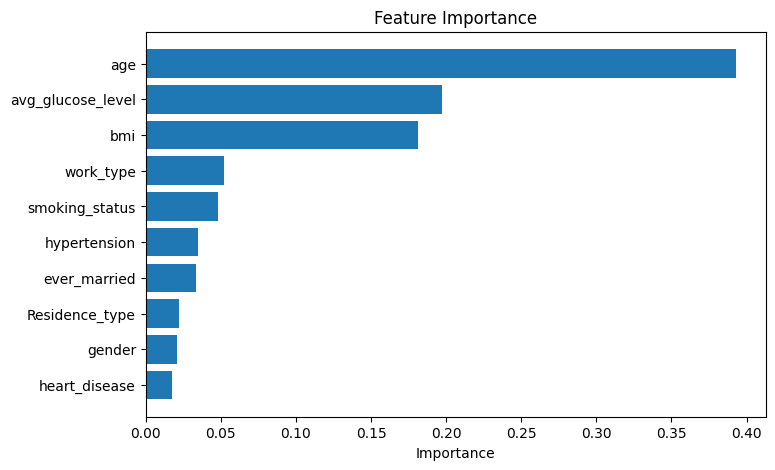

In [ ]:
# Feature importance
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feat_imp = feat_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

### Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning - Logistic Regression
lr_params = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lr_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
                       lr_params, cv=5, scoring='f1')
lr_grid.fit(X_train_scaled, y_train)

print("Best LR params:", lr_grid.best_params_)
print("Best CV score:", lr_grid.best_score_)

Best LR params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.22880060701173774


In [ ]:
# Hyperparameter tuning - Random Forest
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                               rf_params, n_iter=10, cv=5, scoring='f1', random_state=42)
rf_search.fit(X_train_scaled, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best CV score:", rf_search.best_score_)

Best RF params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 5}
Best CV score: 0.2162920053435915


### Feature Selection

In [ ]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=7)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

selected = X.columns[selector.get_support()].tolist()
print("Selected features:", selected)

Selected features: ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi']


In [ ]:
# Final models with best params and selected features
lr_final = LogisticRegression(**lr_grid.best_params_, random_state=42, max_iter=1000, class_weight='balanced')
lr_final.fit(X_train_sel, y_train)
y_pred_lr_final = lr_final.predict(X_test_sel)

rf_final = RandomForestClassifier(**rf_search.best_params_, random_state=42, class_weight='balanced')
rf_final.fit(X_train_sel, y_train)
y_pred_rf_final = rf_final.predict(X_test_sel)

In [ ]:
# Final comparison table
results_class = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Neural Network'],
    'Features': [len(selected), len(selected), X.shape[1]],
    'CV Score': [lr_grid.best_score_, rf_search.best_score_, '-'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr_final), accuracy_score(y_test, y_pred_rf_final), nn_acc],
    'Precision': [precision_score(y_test, y_pred_lr_final, zero_division=0),
                  precision_score(y_test, y_pred_rf_final, zero_division=0), nn_prec],
    'Recall': [recall_score(y_test, y_pred_lr_final, zero_division=0),
               recall_score(y_test, y_pred_rf_final, zero_division=0), nn_rec],
    'F1': [f1_score(y_test, y_pred_lr_final, zero_division=0),
           f1_score(y_test, y_pred_rf_final, zero_division=0), nn_f1]
})
print("Classification Results:")
print(results_class.to_string(index=False))

Classification Results:
              Model  Features  CV Score  Accuracy  Precision  Recall       F1
Logistic Regression         7  0.228801  0.727984   0.129870    0.80 0.223464
      Random Forest         7  0.216292  0.709393   0.124620    0.82 0.216359
     Neural Network        10         -  0.730920   0.128713    0.78 0.220963


## PART B: REGRESSION - Sleep Hours Prediction
Dataset aligns with SDG 3: Good Health and Well-being

In [ ]:
df_reg = pd.read_csv('synthetic_coffee_health_10000.csv')
print("Shape:", df_reg.shape)
df_reg.head()

Shape: (10000, 16)


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

In [ ]:
print("Missing values:", df_reg.isnull().sum().sum())
df_reg.describe()

Missing values: 5941


,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000


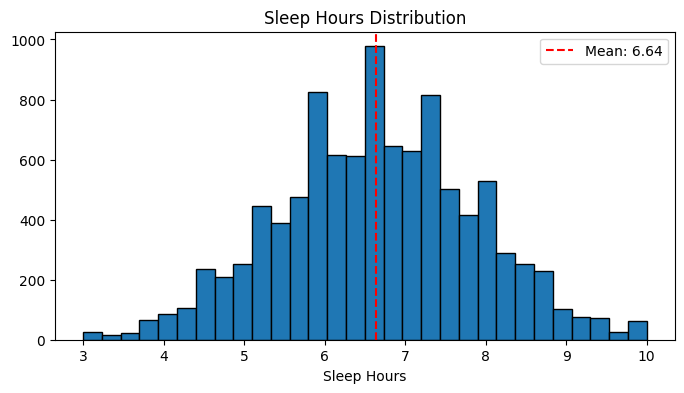

In [ ]:
# Target distribution
plt.figure(figsize=(8, 4))
plt.hist(df_reg['Sleep_Hours'], bins=30, edgecolor='black')
plt.axvline(df_reg['Sleep_Hours'].mean(), color='red', linestyle='--', label=f"Mean: {df_reg['Sleep_Hours'].mean():.2f}")
plt.title('Sleep Hours Distribution')
plt.xlabel('Sleep Hours')
plt.legend()
plt.show()

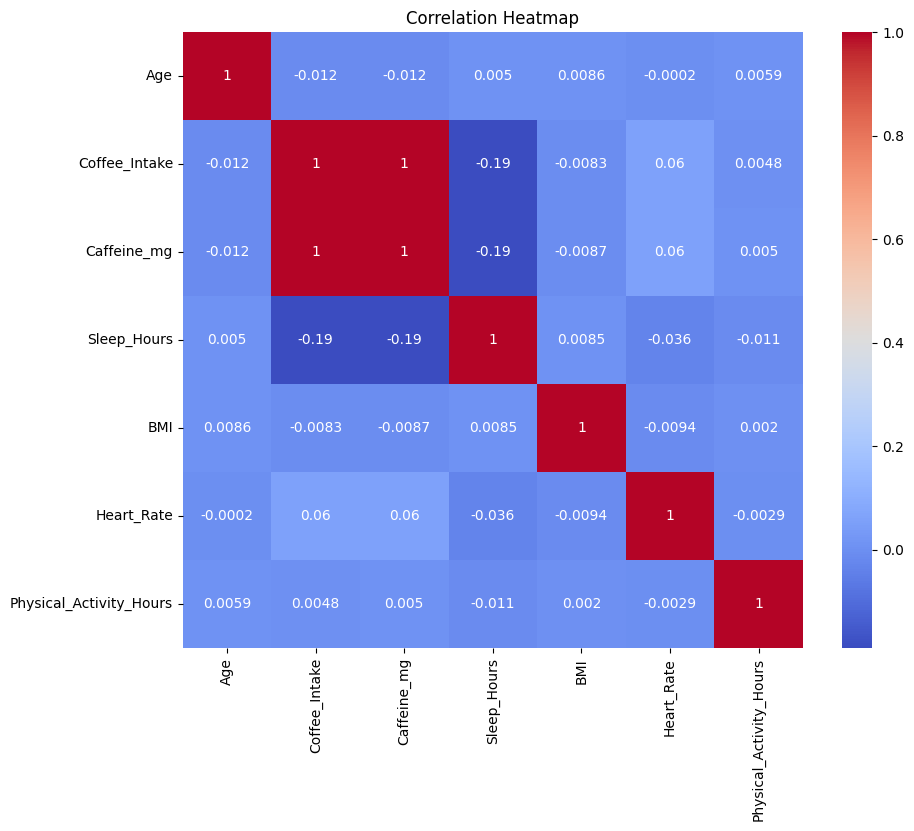

In [ ]:
# Correlation analysis
num_cols_reg = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']
plt.figure(figsize=(10, 8))
sns.heatmap(df_reg[num_cols_reg].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

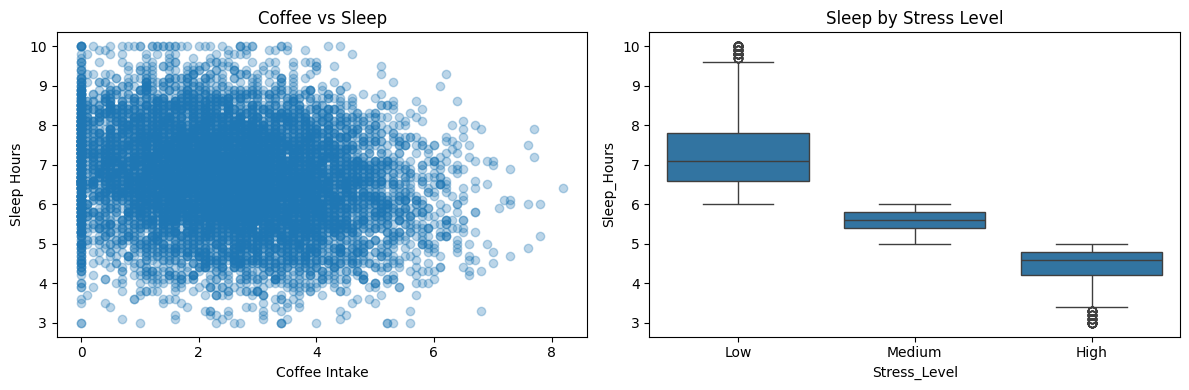

In [ ]:
# Coffee vs Sleep scatter
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(df_reg['Coffee_Intake'], df_reg['Sleep_Hours'], alpha=0.3)
axes[0].set_xlabel('Coffee Intake')
axes[0].set_ylabel('Sleep Hours')
axes[0].set_title('Coffee vs Sleep')

sns.boxplot(x='Stress_Level', y='Sleep_Hours', data=df_reg, ax=axes[1], order=['Low', 'Medium', 'High'])
axes[1].set_title('Sleep by Stress Level')
plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing
df_reg_proc = df_reg.copy()
df_reg_proc = df_reg_proc.drop('ID', axis=1)

cat_cols_reg = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Health_Issues', 'Occupation']
for col in cat_cols_reg:
    le = LabelEncoder()
    df_reg_proc[col] = le.fit_transform(df_reg_proc[col])

X_reg = df_reg_proc.drop('Sleep_Hours', axis=1)
y_reg = df_reg_proc['Sleep_Hours']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_r_sc = scaler_reg.fit_transform(X_train_r)
X_test_r_sc = scaler_reg.transform(X_test_r)

print(f"Train: {X_train_r.shape[0]}, Test: {X_test_r.shape[0]}")

Train: 8000, Test: 2000


### Neural Network Regressor

In [ ]:
model_nn_reg = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_r_sc.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model_nn_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_nn_reg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train regressor
early_stop_reg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_reg = model_nn_reg.fit(
    X_train_r_sc, y_train_r,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_reg],
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 25.4622 - mae: 4.3976 - val_loss: 1.0834 - val_mae: 0.8261
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8492 - mae: 1.3522 - val_loss: 0.8164 - val_mae: 0.7163
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4122 - mae: 1.2403 - val_loss: 0.7076 - val_mae: 0.6606
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1371 - mae: 1.1707 - val_loss: 0.6276 - val_mae: 0.6189
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9442 - mae: 1.1090 - val_loss: 0.5679 - val_mae: 0.5882
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7959 - mae: 1.0627 - val_loss: 0.5559 - val_mae: 0.5801
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7072 - mae: 1.0353 - val_loss: 0.5375 - val_mae: 0.5666
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6299 - mae: 1.0088 - val_loss: 0.4816 - val_mae: 0.5407
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - l

In [ ]:
# Evaluate neural network regressor
y_pred_nn_reg = model_nn_reg.predict(X_test_r_sc).flatten()

nn_mse = mean_squared_error(y_test_r, y_pred_nn_reg)
nn_rmse = np.sqrt(nn_mse)
nn_r2 = r2_score(y_test_r, y_pred_nn_reg)

print("Neural Network Regressor:")
print(f"RMSE: {nn_rmse:.4f}, R2: {nn_r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Regressor:
RMSE: 0.5234, R2: 0.8116


### Classical Regression Models

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_r_sc, y_train_r)
y_pred_lin = lin_reg.predict(X_test_r_sc)

lin_rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_lin))
lin_r2 = r2_score(y_test_r, y_pred_lin)

print("Linear Regression:")
print(f"RMSE: {lin_rmse:.4f}, R2: {lin_r2:.4f}")

Linear Regression:
RMSE: 0.6980, R2: 0.6649


In [ ]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_r_sc, y_train_r)
y_pred_rf_reg = rf_reg.predict(X_test_r_sc)

rf_rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_rf_reg))
rf_r2 = r2_score(y_test_r, y_pred_rf_reg)

print("Random Forest Regressor:")
print(f"RMSE: {rf_rmse:.4f}, R2: {rf_r2:.4f}")

Random Forest Regressor:
RMSE: 0.4998, R2: 0.8282


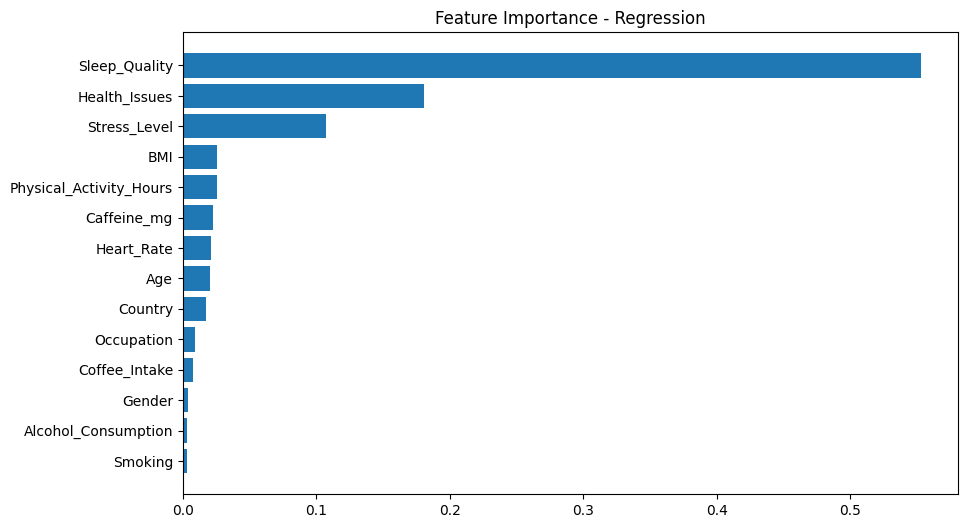

In [ ]:
# Feature importance for regression
feat_imp_reg = pd.DataFrame({'Feature': X_reg.columns, 'Importance': rf_reg.feature_importances_})
feat_imp_reg = feat_imp_reg.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_reg['Feature'], feat_imp_reg['Importance'])
plt.title('Feature Importance - Regression')
plt.gca().invert_yaxis()
plt.show()

### Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for RF Regressor
rf_reg_params = {'n_estimators': [50, 100], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
rf_reg_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_reg_params,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rf_reg_search.fit(X_train_r_sc, y_train_r)

print("Best params:", rf_reg_search.best_params_)
print("Best CV MSE:", -rf_reg_search.best_score_)

Best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Best CV MSE: 0.24596301083453948


### Feature Selection

In [ ]:
# Feature selection using RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42), n_features_to_select=10)
rfe.fit(X_train_r_sc, y_train_r)

selected_reg = X_reg.columns[rfe.support_].tolist()
print("Selected features:", selected_reg)

X_train_r_sel = rfe.transform(X_train_r_sc)
X_test_r_sel = rfe.transform(X_test_r_sc)

Selected features: ['Age', 'Country', 'Caffeine_mg', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation']


In [ ]:
# Final regression models
rf_reg_final = RandomForestRegressor(**rf_reg_search.best_params_, random_state=42)
rf_reg_final.fit(X_train_r_sel, y_train_r)
y_pred_rf_final = rf_reg_final.predict(X_test_r_sel)

lin_reg_final = LinearRegression()
lin_reg_final.fit(X_train_r_sel, y_train_r)
y_pred_lin_final = lin_reg_final.predict(X_test_r_sel)

In [ ]:
# Final regression comparison
results_reg = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Features': [len(selected_reg), len(selected_reg), X_reg.shape[1]],
    'RMSE': [np.sqrt(mean_squared_error(y_test_r, y_pred_lin_final)),
             np.sqrt(mean_squared_error(y_test_r, y_pred_rf_final)), nn_rmse],
    'R2': [r2_score(y_test_r, y_pred_lin_final), r2_score(y_test_r, y_pred_rf_final), nn_r2]
})
print("Regression Results:")
print(results_reg.to_string(index=False))

Regression Results:
            Model  Features     RMSE       R2
Linear Regression        10 0.697433 0.665496
    Random Forest        10 0.491418 0.833927
   Neural Network        14 0.523413 0.811598


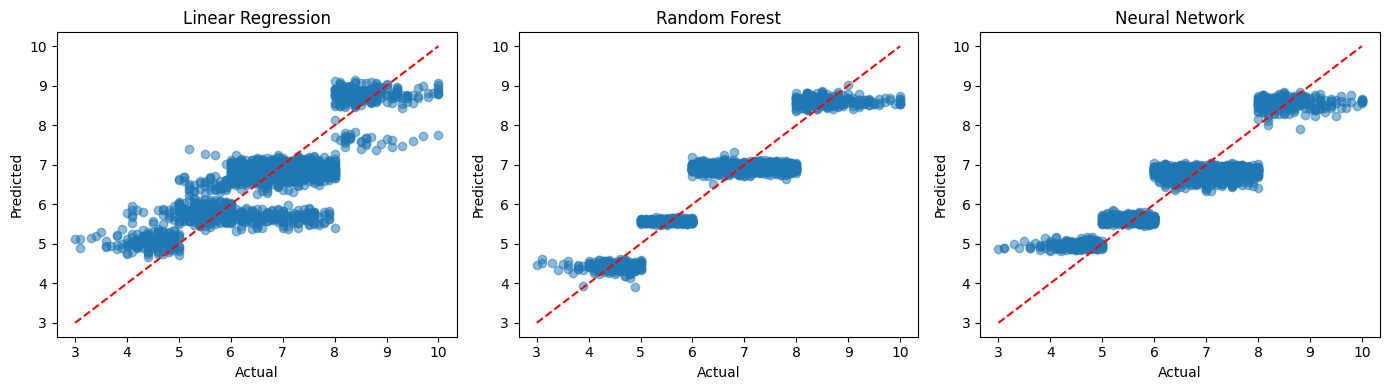

In [ ]:
# Actual vs Predicted plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(y_test_r, y_pred_lin_final, alpha=0.5)
axes[0].plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

axes[1].scatter(y_test_r, y_pred_rf_final, alpha=0.5)
axes[1].plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

axes[2].scatter(y_test_r, y_pred_nn_reg, alpha=0.5)
axes[2].plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

## Conclusion

In [ ]:
print("Classification Summary:")
print("- Age and glucose level are the strongest predictors of stroke")
print("- Class imbalance was handled using class weights")
print("- Feature selection reduced features while maintaining performance")

print("\nRegression Summary:")
print("- Stress level and sleep quality strongly affect sleep hours")
print("- Random Forest performed better than Linear Regression")
print("- Hyperparameter tuning improved model performance")

print("\nBoth tasks align with SDG 3: Good Health and Well-being")

Classification Summary:
- Age and glucose level are the strongest predictors of stroke
- Class imbalance was handled using class weights
- Feature selection reduced features while maintaining performance

Regression Summary:
- Stress level and sleep quality strongly affect sleep hours
- Random Forest performed better than Linear Regression
- Hyperparameter tuning improved model performance

Both tasks align with SDG 3: Good Health and Well-being
